In [ ]:
#  ------------------------------  LISCENCE PLATE ANNOTATION DETECTION  ------------------------------

In [30]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO('runs/detect/train4/weights/best.pt')

def detect_license_plate(image_path):
    # Predict
    results = model(image_path)[0]
    
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    
    # Draw bounding boxes
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls_id = int(box.cls[0])

        # Draw green box and label
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_rgb, f'{model.names[cls_id]} {conf:.2f}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()



image 1/1 C:\Users\anilk\Downloads\numb_plate_rec\test\922.jpg: 416x416 1 license_plate, 77.0ms
Speed: 2.0ms preprocess, 77.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)


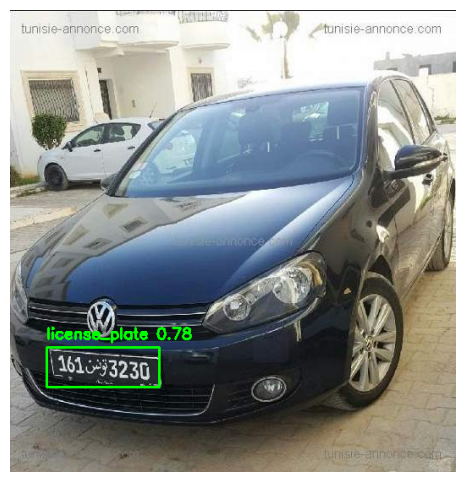

In [31]:
detect_license_plate(r'C:\Users\anilk\Downloads\numb_plate_rec\test\922.jpg')

In [ ]:
#  ------------------------------  TEXT DETECTION FROM LISCENCE PLATE IMAGE  ------------------------------

In [32]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("license_plate_model.h5")

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 128
characters = ['0','1','2','3','4','5','6','7','8','9','N','T','blank']
char_to_idx = {c: i for i, c in enumerate(characters)}
idx_to_char = {i: c for c, i in char_to_idx.items()}


def preprocess_image(img_path):
   
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return np.expand_dims(img, axis=0)  # Add batch dimension

def decode_prediction(preds):
    decoded = ''
    for p in preds:
        idx = np.argmax(p[0])  # p[0] because shape is (1, num_classes)
        char = idx_to_char[idx]
        if char != 'blank':
            decoded += char
    return decoded


import matplotlib.pyplot as plt
import cv2

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Shape: (64, 128, 1)
    return np.expand_dims(img, axis=0)  # Shape: (1, 64, 128, 1)

def decode_prediction(preds):
    decoded = ''
    for p in preds:
        idx = np.argmax(p[0])  # p is shape (1, NUM_CLASSES)
        char = idx_to_char[idx]
        if char != 'blank':
            decoded += char
    return decoded




1/1 [==============================] - 0s 363ms/step
133T6719


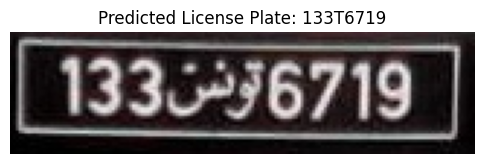

In [33]:
# Path to image
img_path = r"C:\Users\anilk\Downloads\numb_plate_rec\license_plates_recognition_train\100.jpg"

# Preprocess and predict
input_image = preprocess_image(img_path)
preds = model.predict(input_image)
predicted_text = decode_prediction(preds)
print(predicted_text)

# Show the image with prediction
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for plt

plt.figure(figsize=(6, 3))
plt.imshow(img_rgb)
plt.title(f"Predicted License Plate: {predicted_text}")
plt.axis('off')
plt.show()

In [ ]:
#  ------------------------------ PIPELINE OF TRAINED MODELS - text recognition in car image(liscence plate included) ------------------------------

#  ------------------------------ LISCENCE PLATE ANNOTATION DETECTION + TEXT DETECTION FROM LISCENCE PLATE IMAGE  ------------------------------

In [34]:
import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import random

# Load both models
yolo_model = YOLO('runs/detect/train4/weights/best.pt')  # YOLO detection model
ocr_model = load_model("license_plate_model.h5")         # Text recognition model

# OCR configuration
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 128
characters = ['0','1','2','3','4','5','6','7','8','9','N','T','blank']
char_to_idx = {c: i for i, c in enumerate(characters)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

def preprocess_for_ocr(image):
    """Preprocess cropped license plate image for OCR"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (IMAGE_WIDTH, IMAGE_HEIGHT))
    gray = gray.astype(np.float32) / 255.0
    gray = np.expand_dims(gray, axis=-1)  # Add channel dimension
    return np.expand_dims(gray, axis=0)   # Add batch dimension

def decode_prediction(preds):
    """Decode OCR model predictions to text"""
    decoded = ''
    for p in preds:
        idx = np.argmax(p[0])  # p[0] because shape is (1, num_classes)
        char = idx_to_char[idx]
        if char != 'blank':
            decoded += char
    return decoded

def process_single_image(image_path):
    """Process a single image through both models"""
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return
    
    print(f"\nProcessing: {os.path.basename(image_path)}")
    
    # Detect license plates with YOLO
    results = yolo_model(image)[0]
    
    # If no license plates found
    if len(results.boxes) == 0:
        print("No license plates detected in this image")
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("No license plates detected")
        plt.axis('off')
        plt.show()
        return
    
    # Process each detected license plate
    for i, box in enumerate(results.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        
        # Crop license plate region
        plate_img = image[y1:y2, x1:x2]
        
        # Preprocess and recognize text
        ocr_input = preprocess_for_ocr(plate_img)
        preds = ocr_model.predict(ocr_input)
        plate_text = decode_prediction(preds)
        
        # Draw bounding box and text on original image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{plate_text} ({conf:.2f})"
        cv2.putText(image, label, (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # Show cropped plate
        print(f"Plate {i+1}: {plate_text} (confidence: {conf:.2f})")
        plt.figure(figsize=(3, 1.5))
        plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Plate {i+1}: {plate_text}")
        plt.axis('off')
        plt.show()
    
    # Show final result
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Result: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()



Processing: 1083.jpg

0: 416x320 1 license_plate, 62.2ms
Speed: 2.0ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 320)
1/1 [==============================] - 0s 300ms/step
Plate 1: 148T2903 (confidence: 0.80)


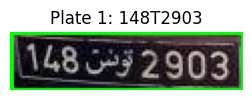

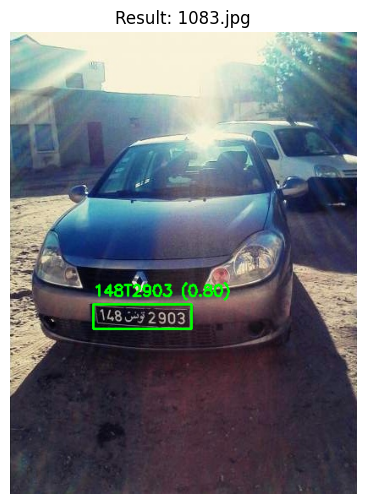

In [35]:
img_path=r"C:\Users\anilk\Downloads\numb_plate_rec\test\1083.jpg"
process_single_image(img_path)